In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
def feature_summary(df_fa):
    print('DataFrame shape')
    print('rows:',df_fa.shape[0])
    print('cols:',df_fa.shape[1])
    col_list=['Null','Unique_Count','Data_type','Max/Min','Mean','Std','Skewness','Sample_values']
    df=pd.DataFrame(index=df_fa.columns,columns=col_list)
    df['Null']=list([len(df_fa[col][df_fa[col].isnull()]) for i,col in enumerate(df_fa.columns)])
    #df['%_Null']=list([len(df_fa[col][df_fa[col].isnull()])/df_fa.shape[0]*100 for i,col in enumerate(df_fa.columns)])
    df['Unique_Count']=list([len(df_fa[col].unique()) for i,col in enumerate(df_fa.columns)])
    df['Data_type']=list([df_fa[col].dtype for i,col in enumerate(df_fa.columns)])
    for i,col in enumerate(df_fa.columns):
        if 'float' in str(df_fa[col].dtype) or 'int' in str(df_fa[col].dtype):
            df.at[col,'Max/Min']=str(round(df_fa[col].max(),2))+'/'+str(round(df_fa[col].min(),2))
            df.at[col,'Mean']=df_fa[col].mean()
            df.at[col,'Std']=df_fa[col].std()
            df.at[col,'Skewness']=df_fa[col].skew()
        df.at[col,'Sample_values']=list(df_fa[col].unique())
           
    return(df.fillna('-'))

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [7]:
df = pd.read_csv('C:\\Users\\shac\\Documents\\dataframe.csv')

In [8]:
feature_summary(df)

DataFrame shape
rows: 699
cols: 2


,Null,Unique_Count,Data_type,Max/Min,Mean,Std,Skewness,Sample_values
CalendarDate,0,699,object,-,-,-,-,"[2018-10-04 00:00:00.000, 2017-01-24 00:00:00...."
Sales,0,699,float64,43621106.01/6874.97,1.70921e+07,1.23339e+07,-0.157645,"[25126897.938599996, 21198263.5428, 12857754.6..."


In [9]:
df.CalendarDate = pd.to_datetime(df.CalendarDate)
df = df.set_index('CalendarDate')

In [10]:
df = df.sort_index(axis=0)
df.head()

,Sales
CalendarDate,
2017-01-01,2.510354e+05
2017-01-02,2.922824e+06
2017-01-03,2.187791e+07
2017-01-04,1.786154e+07
2017-01-05,1.657368e+07


In [48]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(df.Sales.copy())
data.columns = ["y"]

In [49]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [31]:
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
CalendarDate,,,,,,,,,,,,,,,,,,,,,
2018-11-26,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,3.256968e+06,5.915519e+05,...,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06,4.298194e+05,1.314414e+07
2018-11-27,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,3.256968e+06,...,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06,4.298194e+05
2018-11-28,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,...,3.063981e+07,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06
2018-11-29,2.438517e+07,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,...,3.332149e+07,3.063981e+07,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07
2018-11-30,2.147449e+07,2.438517e+07,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,...,2.254101e+07,3.332149e+07,3.063981e+07,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [50]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [51]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [52]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

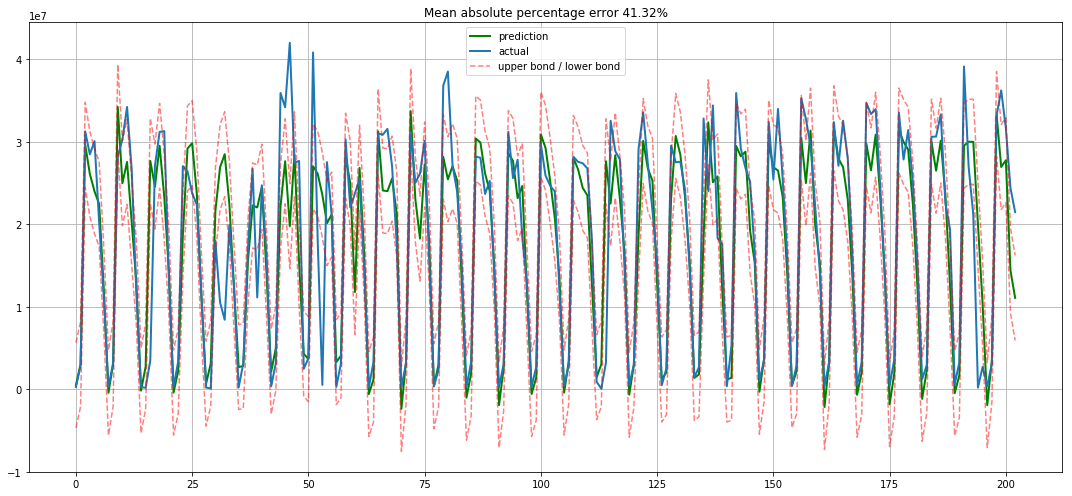

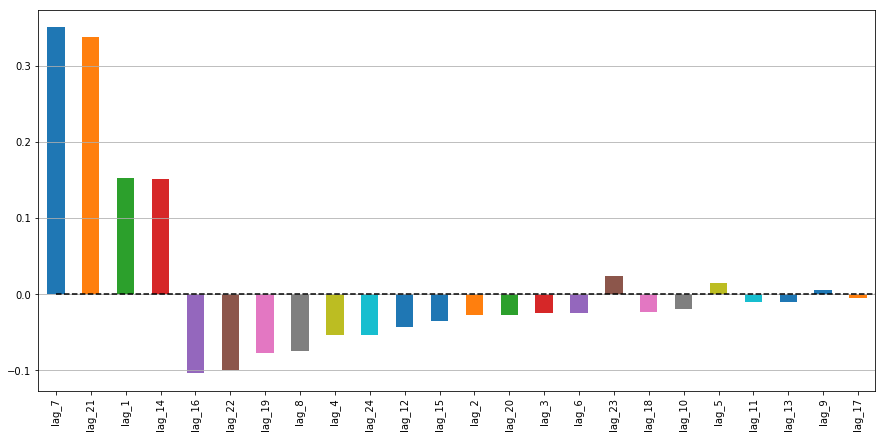

In [36]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [37]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
CalendarDate,,,,,,,,,,,,,,,,,,,,,
2018-11-26,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,3.256968e+06,5.915519e+05,...,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06,4.298194e+05,1.314414e+07,0,0
2018-11-27,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,3.256968e+06,...,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06,4.298194e+05,1,0
2018-11-28,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,3.913573e+07,...,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3.598043e+06,2,0
2018-11-29,2.438517e+07,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,2.695415e+07,...,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,3.354193e+07,3,0
2018-11-30,2.147449e+07,2.438517e+07,3.167848e+07,3.624241e+07,3.319004e+07,3.080753e+06,4.059052e+05,2.701944e+06,1.993833e+05,2.115915e+07,...,3.063981e+07,3.061847e+07,2.938709e+06,1.227594e+06,1.529243e+07,2.510903e+07,3.142582e+07,2.786050e+07,4,0


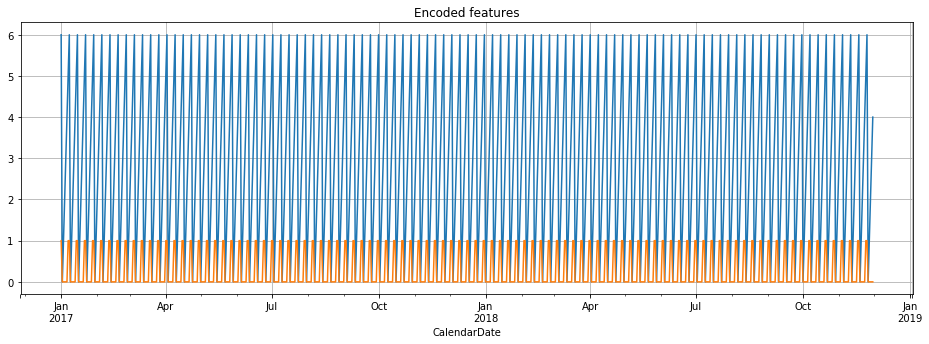

In [38]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [44]:
data = data[['y','lag_7','lag_21','lag_14','lag_1','lag_24','lag_16','lag_4','lag_19','lag_12','lag_18','lag_5','lag_22']]

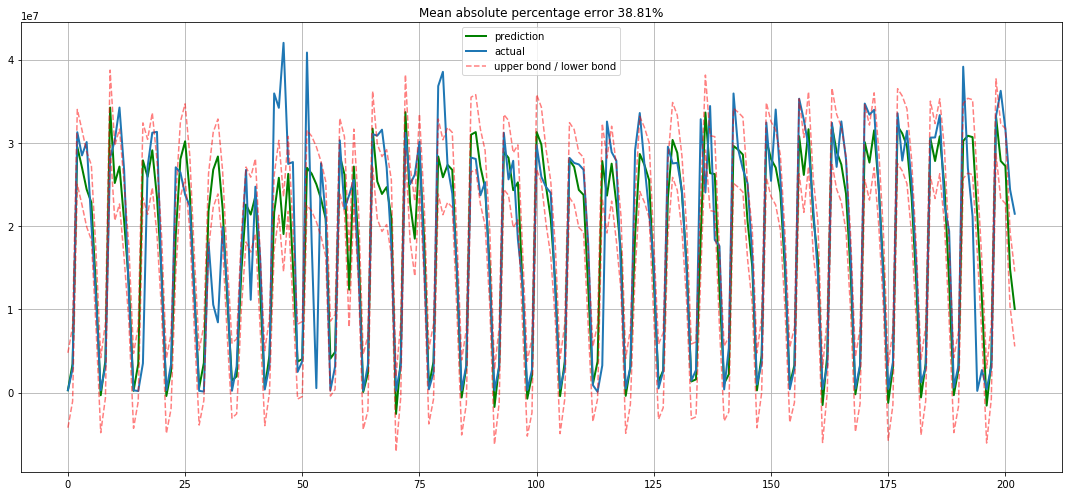

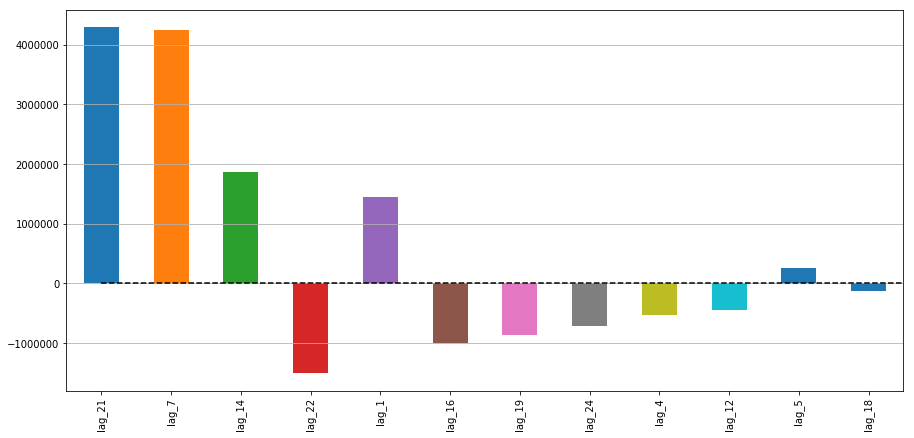

In [45]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

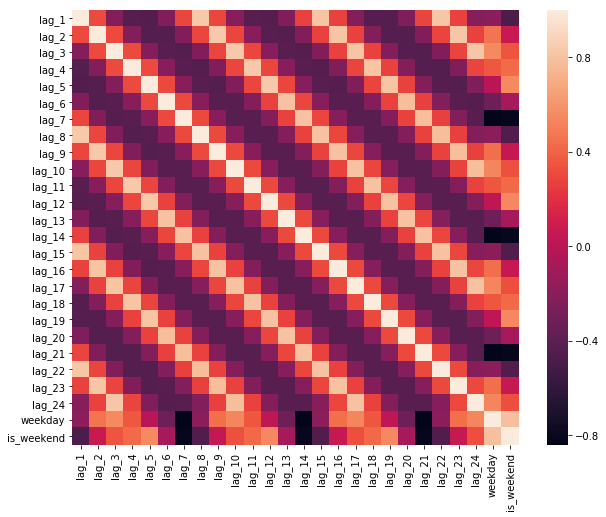

In [183]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

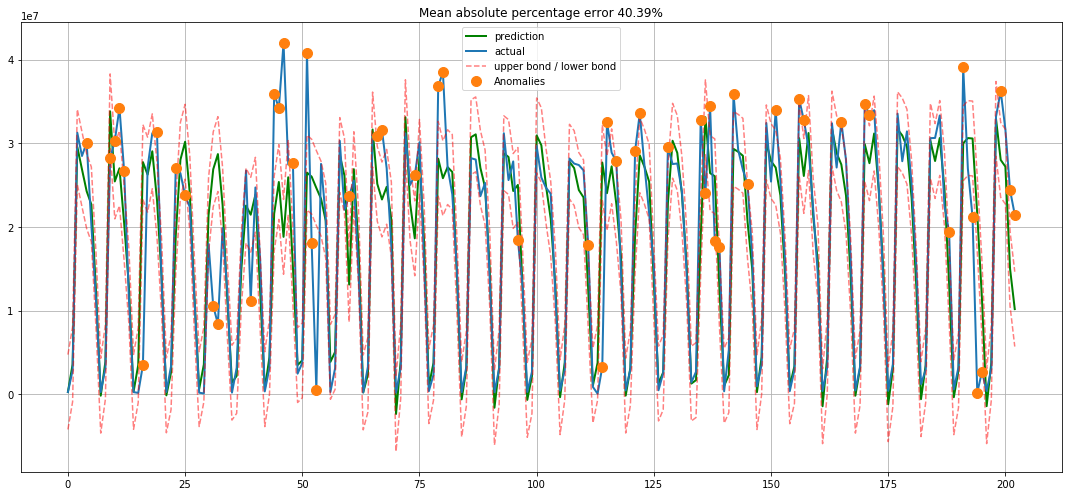

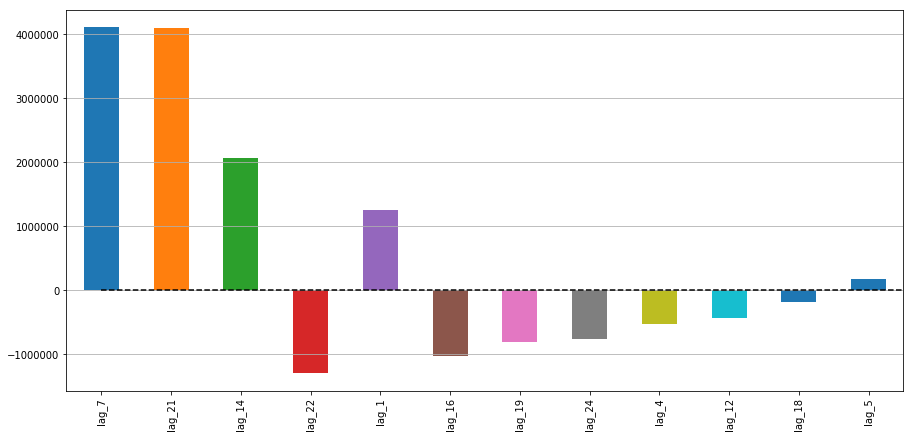

In [281]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

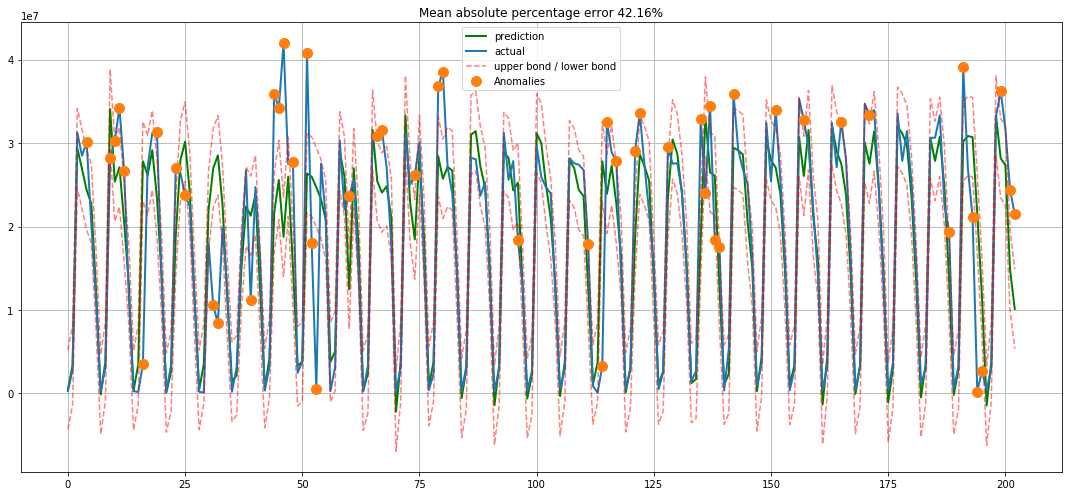

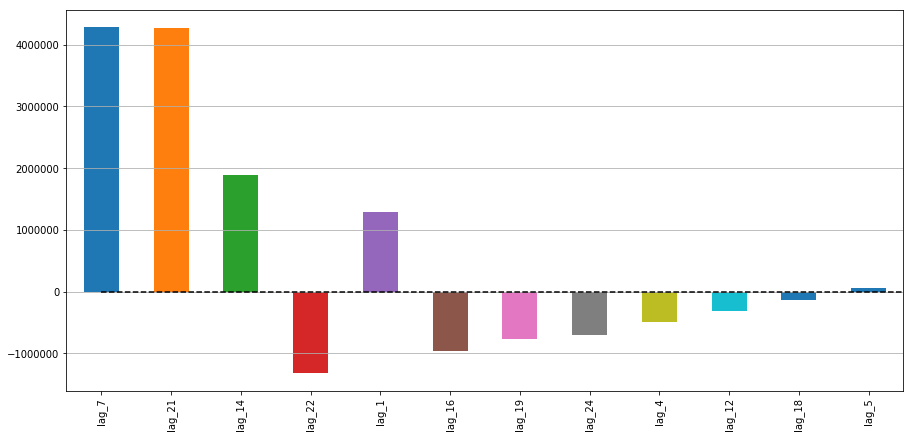

In [282]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [1]:
import xgboost

In [53]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train);

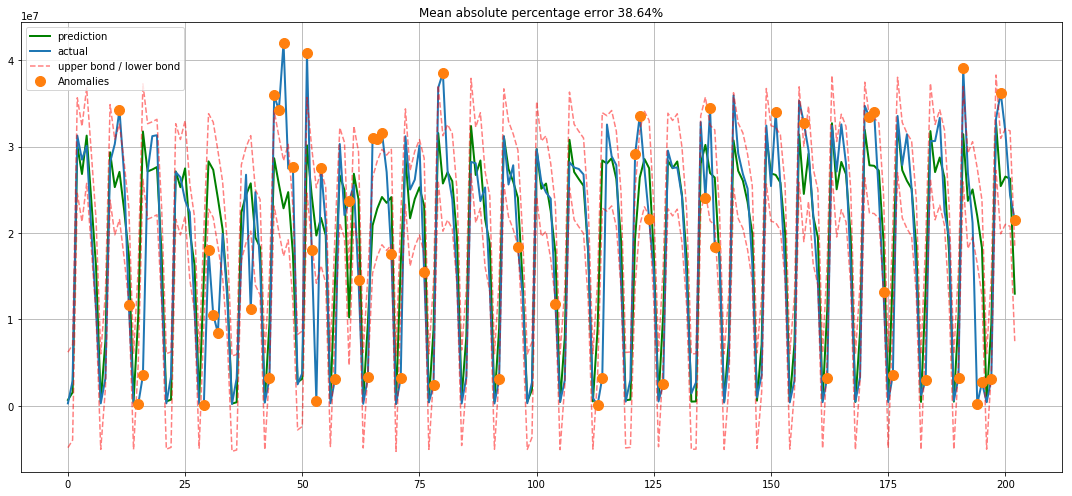

In [54]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)